In [6]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.utils import np_utils

In [3]:
! pip install scikit-plot

In [10]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [12]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [13]:
emotion_label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

In [14]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [15]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

In [16]:
INTERESTED_LABELS = [2, 3, 4, 6]

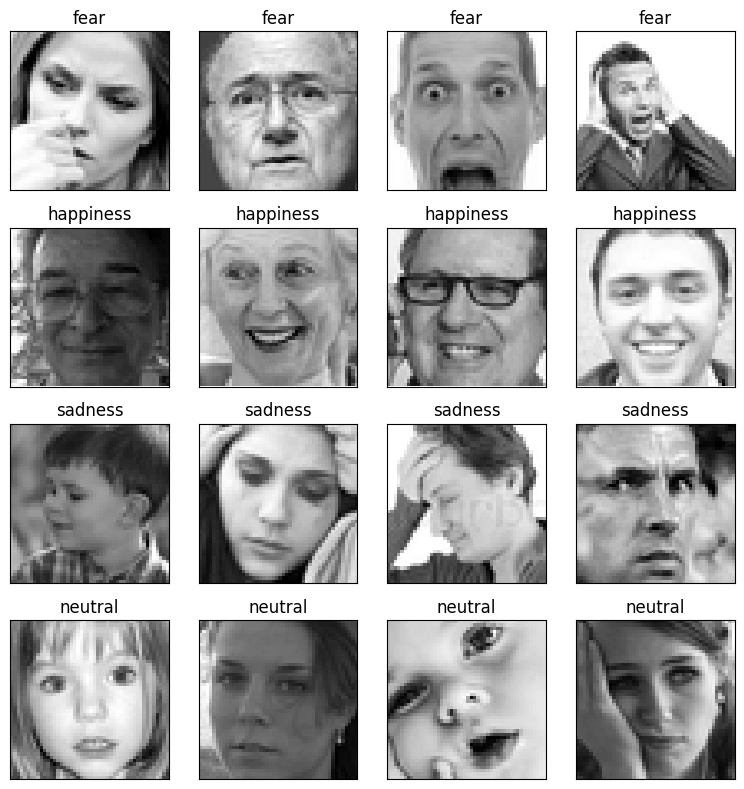

In [17]:
fig = pyplot.figure(1, (8, 8))

k = 0
for label in sorted(INTERESTED_LABELS):
    for j in range(4):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(4, 4, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [18]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(26385, 3)

In [19]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [20]:
img_array.shape

(26385, 48, 48, 1)

In [22]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
img_labels = label_encoder.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape


(26385, 4)

In [23]:
label_encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_encoder_name_mapping)

{2: 0, 3: 1, 4: 2, 6: 3}


In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((23746, 48, 48, 1), (2639, 48, 48, 1), (23746, 4), (2639, 4))

In [25]:
del df
del img_array
del img_labels

In [26]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [27]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [28]:
def build_net(optim):
    net = Sequential(name='CNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [29]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [30]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [31]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0       

C:\Users\Window\AppData\Local\Temp\ipykernel_4352\1891377629.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100


Exception in thread Thread-10 (_run):
Traceback (most recent call last):
  File "c:\Users\Window\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Window\AppData\Local\Programs\Python\Python310\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Window\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\data_utils.py", line 829, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\Users\Window\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\data_utils.py", line 804, in pool_fn
    pool = get_pool_class(True)(
  File "c:\Users\Window\AppData\Local\Programs\Python\Python310\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "c:\Users\Window\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py", line 215

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save("model.keras")

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [ ]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')

In [ ]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')

In [ ]:
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:
mapper = {
    0: "fear"
    1: "happy",
    2: "sad",
    3: "neutral",
}

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

In [ ]:
def plot_miss_classified(emotion):
    ytest_ = np.argmax(y_valid, axis=1)
    text_to_label = dict((v,k) for k,v in mapper.items())
    miss_happy_indices = np.where((ytest_ != yhat_valid) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_valid[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = mapper[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")   

In [ ]:
plot_miss_classified(emotion="happy")
plot_miss_classified(emotion="fear")
plot_miss_classified(emotion="sad")
plot_miss_classified(emotion="neutral")